2000


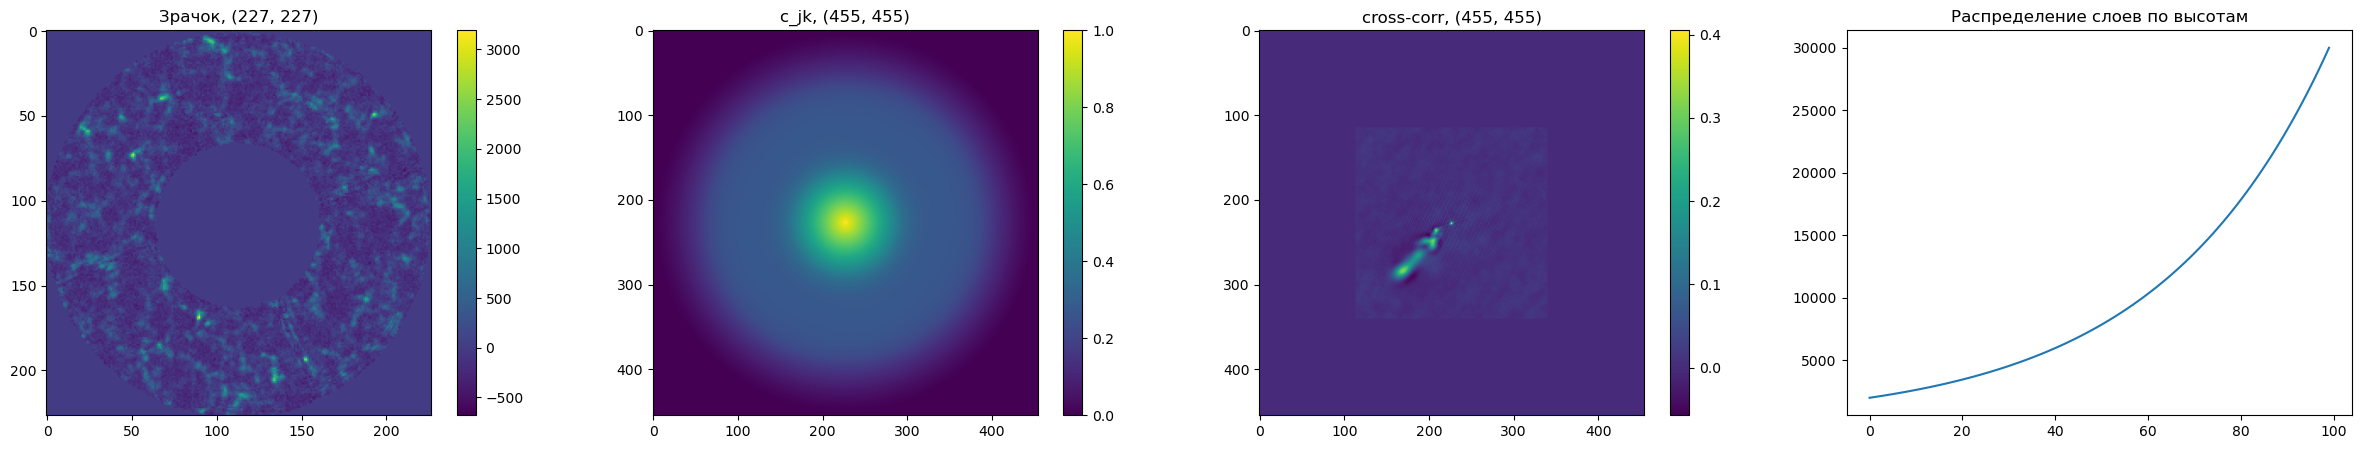

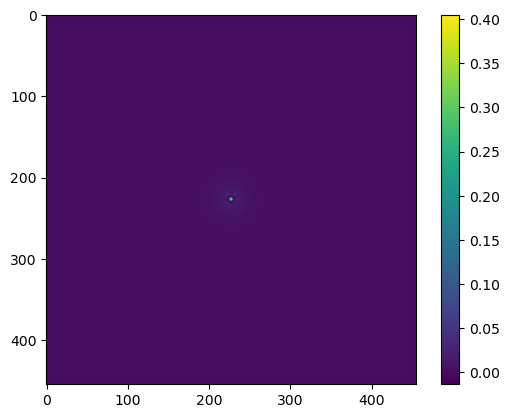

In [90]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from IPython.display import clear_output
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return -1
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return np.argwhere(myList==after)[0][0]
    else:
        return np.argwhere(myList==before)[0][0]

def c_jk(data, Dpix):
    nx = 2 * Dpix + 1 # ширина окна для автокорреляции зрачка (должно быть минимум в 2 раза больше, чем ширина зрачка)
    I0c = (data != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    return res, nx

def gamma_poly_se(X, Y, Vx, Vy, z):
    global cjk, t, a1, gammas, data
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta 
    
    count = take_closest(a1, z)
    res = gammas[count]
    

    res = shift(res, (-Ypix, Xpix), order=1) 
    res = res * cjk
    
    k = np.max(data[data.shape[0]//2-int(Ypix)-1:data.shape[0]//2-int(Ypix)+2, 
                    data.shape[1]//2+int(Xpix)-1:data.shape[1]//2+int(Xpix)+2]) / np.max(res)
    res = res * k
#     print(z)
#     print('Cn2:', 1e-13 * k)
    return res, k

# ----------- входные параметры
D = 2.5
latency = 4
sec_per_frame = 0.01
t = sec_per_frame * latency

# ---------- считывание зрачка и картины мерцаний
pupil = np.loadtxt('C:/astro/domecam/data.gz')
data = np.loadtxt('C:/astro/domecam/data_corr4.gz')
a = int(2*pupil.shape[0]+2 - data.shape[0])//2
b = int(2*pupil.shape[1]+2 - data.shape[1])//2
data = np.pad(data, ((a, a), (b, b)), 'constant', constant_values=(0))

# ------------- распределение слоев по высотам
a1 = 3*np.logspace(2.824, 4, num=100, base=10)
a1[0]=2000

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

# ------------- c_jk
cjk, nx = c_jk(pupil, pupil.shape[0])
f_scale = pupil.shape[0]/(D*nx)
delta = D/pupil.shape[0] 

# -------------- гаммы
gammas = np.load(f'C:/astro/domecam/gammas.npy')


fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr, {data.shape}')

ax4.plot(a1)
ax4.set_title('Распределение слоев по высотам')

plt.figure()
plt.imshow(gamma_poly_se(X, Y, 0, 0, 2000)[0])
plt.colorbar()

In [91]:
def multi_speckle_fit(params=None, ydata=None):
    global xdata, sec_per_frame, latency, delta, z_0
    def speckle_fit(xcoord, ycoord, z_dist, ydata): # аппроксимация одного слоя
        k=50
        def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
            x, y = M
            arr = np.zeros(x.shape)
            for i in range(len(args)//3):
                arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
            return arr
        
        params = [(xcoord, ycoord, z_dist)] # подгонка типа ввода параметров под функцию
        p0 = [p for prms in params for p in prms]
        
        st=time.perf_counter()
        
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        t = sec_per_frame * latency
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)

        fit = np.zeros(X.shape) # результирующее изображение
        xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
        ydata = ydata.ravel()
        print(z_dist, p0)
        
        popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[[xcoord-3, ycoord-3, 0],
                                                             [xcoord+3, ycoord+3, 50000]]) 
        print(popt)
        print(f'Fitted parametrs: {popt[0]:.2f} {popt[1]:.2f} {popt[2]}')
        k_coeff=[]
        for i in range(len(popt)//3):
            fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
            k_coeff.append(gamma_poly_se(X, Y, *popt[i*3:i*3+3])[1])

        print(f'Time: {time.perf_counter()-st:.4f}')
    
        t = sec_per_frame * latency
        Xpix = int(popt[0]*t/delta)
        Ypix = int(popt[1]*t/delta)
    
        return fit, Xpix, Ypix, k_coeff
    
    myParams = [p for prms in params for p in prms]
    res = np.zeros(data.shape)
    cr = data.shape[0]//2 # центр изображения
    Xc = []
    Yc = []
    Cn2 = []
    t = sec_per_frame * latency

    for i in range(len(myParams)//3):
        print(f'Speckle fitting:', *myParams[i*3:i*3+3])
        fit, xcoord, ycoord, Cn2_fitted = speckle_fit(*myParams[i*3:i*3+3], ydata)
        res[(res.shape[0]//2 - ycoord) - fit.shape[0]//2:(res.shape[0]//2 - ycoord) + fit.shape[0]//2, 
            (res.shape[1]//2 + xcoord) - fit.shape[1]//2:(res.shape[1]//2 + xcoord) + fit.shape[1]//2] += fit
        Xc.append(xcoord)
        Yc.append(ycoord)
        Cn2.append(Cn2_fitted)
        print(f'-max fitted value: {np.max(fit):.2f}')
        print(f'-max initial value: {np.max(data[cr-ycoord-4:cr-ycoord+4, cr+xcoord-4:cr+xcoord+4]):.2f}')
        print('')
    
    return res, Xc, Yc, Cn2

Speckle fitting: 0 0 2001
2001 [0, 0, 2001]
2001.0
2001.0
2001.0
2001.0000298172235
2001.0
2001.0
2001.0
2001.0000298172235
2001.0
2001.0
2001.0
2001.0000298172235
2001.0
2001.0
2001.0
2001.0000298172235
2001.0
2001.0
2001.0
2001.0000298172235
2001.0
2001.0
2001.0
2001.0000298172235
2001.0
2001.0
2001.0
2001.0000298172235
[ 7.80546904e-02 -1.74909021e-01  2.00100000e+03]
Fitted parametrs: 0.08 -0.17 2001.0
2001.0
2001.0
Time: 0.1802
-max fitted value: 0.41
-max initial value: 0.41

Speckle fitting: -7.5 -7.5 10000
10000 [-7.5, -7.5, 10000]
10000.0
10000.0
10000.0
10000.000149011612
10000.0
10000.0
10000.0
10000.000149011612
10000.0
10000.0
10000.0
10000.000149011612
10000.0
10000.0
10000.0
10000.000149011612
10000.0
10000.0
10000.0
10000.000149011612
10000.0
10000.0
10000.0
10000.0
10000.000149011612
10000.0
10000.0
10000.0
10000.0
10000.000149011612
10000.0
10000.0
10000.0
10000.0
10000.000149011612
10000.0
10000.0
10000.0
10000.0
10000.000149011612
10000.0
10000.0
10000.0
10000.0
100

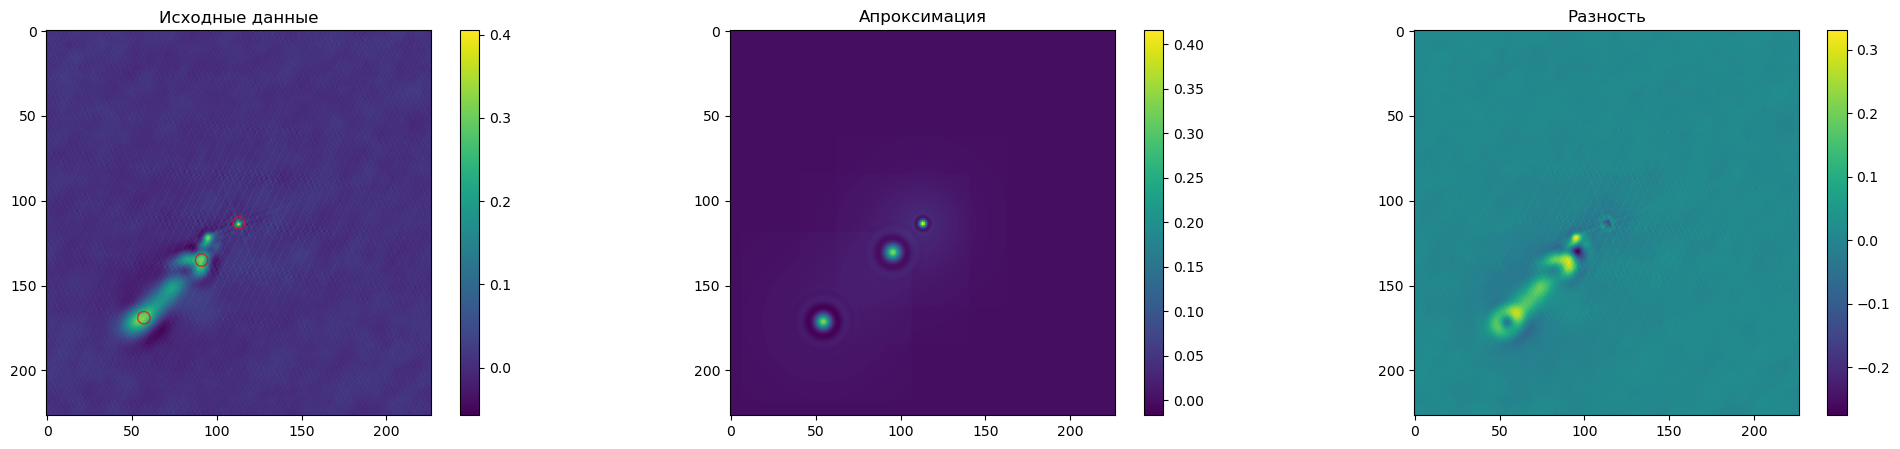

In [92]:
myParams = [( 0,   0, 2001),
            (-7.5, -7.5, 10000),
            (-15, -15, 10000)]

fit, speckle_x, speckle_y, Cn2_values = multi_speckle_fit(params=myParams, ydata=data)

# -----------------------------------------------------------
lambda_=500*pow(10, -9) # нм
k = 2*np.pi/lambda_
r0 = pow(0.423*pow(k, 2)*(np.sum(1e-13*np.array(Cn2_values))), -3/5)
print(' ')
print('sum Cn2:', np.sum(1e-13*np.array(Cn2_values)))
print('r0, sm:', 100*r0)
print('seeing, arcsec:', 0.98 * 206265 * lambda_/r0)

# ------------ Отрисовка ---------------------------
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
cr = data[a:data.shape[0]-a, b:data.shape[1]-b].shape[0]//2 # центр изображения

fig.colorbar(ax.imshow(data[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax)
ax.set_title('Исходные данные')
fig.colorbar(ax2.imshow(fit[a:fit.shape[0]-a, b:fit.shape[1]-b]), ax=ax2)
ax2.set_title('Апроксимация')
fig.colorbar(ax3.imshow((data-fit)[a:data.shape[0]-a, b:data.shape[1]-b]), ax=ax3)
ax3.set_title('Разность')
for i in range(len(speckle_x)):
    ax.scatter(cr+speckle_x[i], cr-speckle_y[i], alpha=0.7, s=80, facecolors='none', edgecolors='r')

print('')